In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def gridsearch_timeseriessplit(trend_type, seasonal_type, damped_trend, init_method):

    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []

    for train_idx, val_idx in tss.split(df_close):
        train = df_close.iloc[train_idx]
        test = df_close.iloc[val_idx]
                       

        if seasonal_type != None:

            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type,
                  seasonal_periods=14)
        else:
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type)

        res_hw = hw.fit()
        fcast = res_hw.forecast(len(test))
        
        rmse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=False)
        root_mean_squared_errors.append(rmse)
        mse = mean_squared_error(test['eth_close'], np.exp(fcast), squared=True)
        mean_squared_errors.append(mse)        
        mae = mean_absolute_error(test['eth_close'], np.exp(fcast))
        mean_absolute_errors.append(mae)
        mape = mean_absolute_percentage_error(test['eth_close'], np.exp(fcast))
        mean_absolute_percentage_errors.append(mape)
        

    #plt.show()

    print("Tesztelve 5 különböző tanulási/tesztelési adatszetten")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")
    return np.mean(root_mean_squared_errors), np.mean(mean_squared_errors), np.mean(mean_absolute_errors), np.mean(mean_absolute_percentage_errors)

In [4]:
df = pd.read_csv('training_dataset.csv', index_col='date', parse_dates=True)

In [5]:
df.head()

,eth_low,eth_high,eth_open,eth_close,eth_volume,month,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,...,stochastic_oscillator,ma_12,ma_26,ema_12,ema_26,obv,mfi,upper_band,middle_band,lower_band
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,383.18,394.39,386.44,388.46,4198.68434,2017-09-01,1.635228e+06,4124.0,1564.05531,6.096309e+05,...,96.424850,346.524167,338.660000,346.524167,338.660000,1.378006e+06,88.346876,411.653941,341.8790,272.104059
2017-09-02,320.08,394.32,388.58,343.14,8240.32724,2017-09-01,2.904008e+06,8217.0,2460.66776,8.684873e+05,...,97.629707,348.178333,339.773462,348.178333,339.773462,1.369766e+06,80.426793,411.386517,341.6590,271.931483
2017-09-03,320.08,367.28,343.56,341.77,5253.62211,2017-09-01,1.801703e+06,6153.0,2240.91753,7.679383e+05,...,79.514749,350.842500,340.706923,350.842500,340.706923,1.364512e+06,74.419284,408.329187,340.1235,271.917813
2017-09-04,267.94,344.55,339.29,283.77,6737.81061,2017-09-01,2.002446e+06,7403.0,2954.16805,8.770111e+05,...,78.967144,348.178333,339.138077,348.178333,339.138077,1.357774e+06,67.246410,404.443029,335.1070,265.770971
2017-09-05,235.55,321.52,286.81,312.09,8344.41924,2017-09-01,2.397491e+06,8999.0,4312.97282,1.251959e+06,...,55.783836,347.234167,338.443846,347.234167,338.443846,1.366118e+06,66.412993,396.369992,331.2515,266.133008


In [6]:
df.index.freq = "D"

In [7]:
df.index

DatetimeIndex(['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04',
               '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08',
               '2017-09-09', '2017-09-10',
               ...
               '2023-02-26', '2023-02-27', '2023-02-28', '2023-03-01',
               '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05',
               '2023-03-06', '2023-03-07'],
              dtype='datetime64[ns]', name='date', length=2014, freq='D')

In [8]:
df_close = pd.DataFrame(df.eth_close)

<Axes: xlabel='date'>

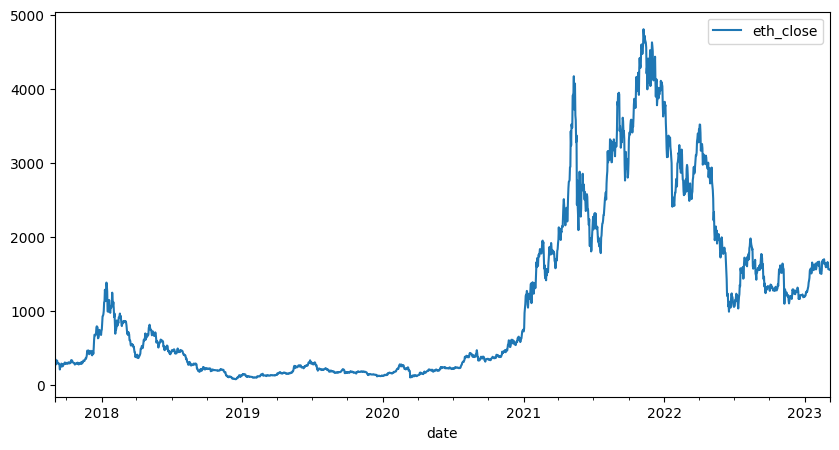

In [9]:
df_close.plot(figsize=(10,5))

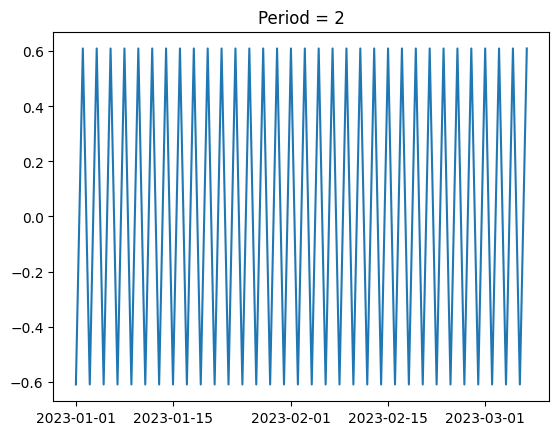

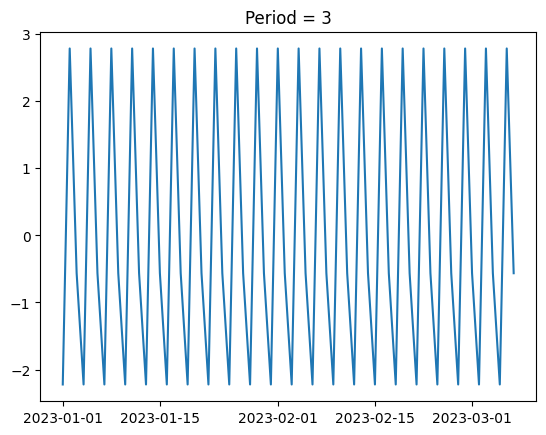

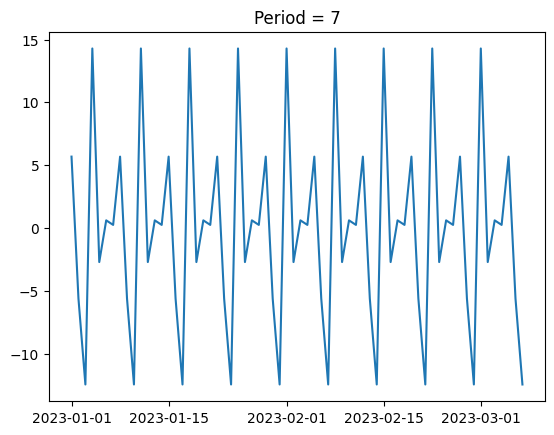

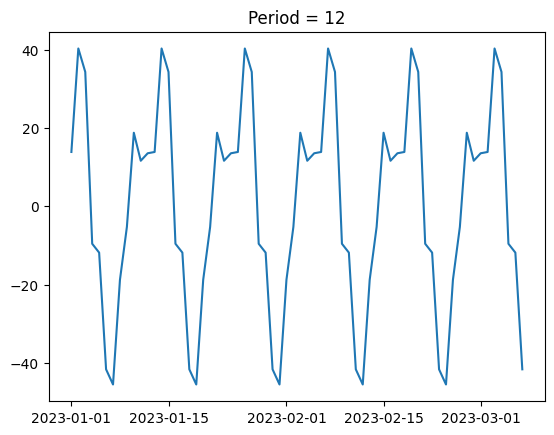

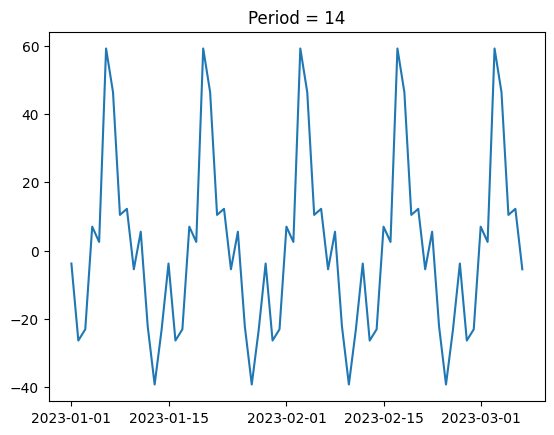

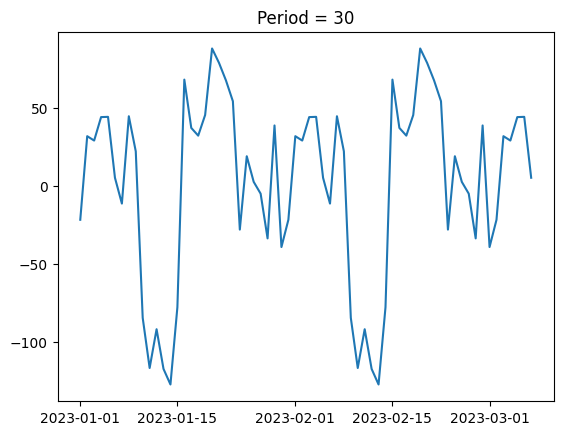

In [10]:
## Choose the appropriate period = 365
for period in [2, 3,7,12,14,30]:
    result = seasonal_decompose(df.eth_close[pd.to_datetime("2023-01-01"):], period=period)
    plt.plot(result.seasonal)
    plt.title(f"Period = {period}")
    plt.show()


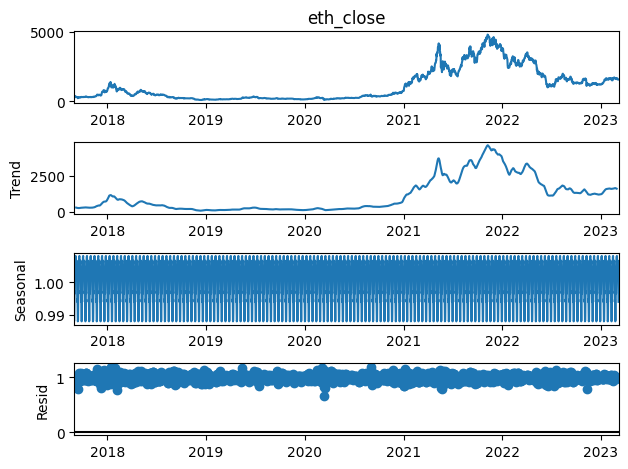

In [11]:
##Only 3 day period shows a possible seasonality
seasonality_trend = seasonal_decompose(df_close.eth_close, model="multiplicative", period=14)
seasonality_trend.plot()
plt.savefig("charts/forecast/holt-winter-season-trend-decompose.png")
plt.show()

In [12]:
df_close["logclose"] = np.log(df_close.eth_close)

<Axes: xlabel='date'>

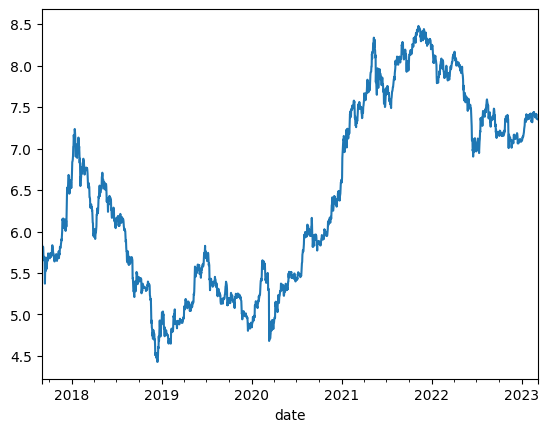

In [13]:
df_close["logclose"].plot()

In [14]:
df_close.shape

(2014, 2)

## Test on Validation set and best options

## Timeseries Split

## 1 DAY

In [15]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=1, gap=0)
df_close = df_close.sort_index()

In [16]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [17]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [18]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 27.3322
MSE: 1496.7743
MAE: 27.3322
MAPE: 1.6999%
RMSE: 27.332245737414702, MSE: 1496.7742560945176, MAE: 27.332245737414702, MAPE: 0.01699914436060782
Best RMSE so far: 27.332245737414702
add add True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 27.3322
MSE: 1496.7743
MAE: 27.3322
MAPE: 1.6999%
RMSE: 27.332245737414702, MSE: 1496.7742560945176, MAE: 27.332245737414702, MAPE: 0.01699914436060782
add add True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 27.3344
MSE: 1496.8285
MAE: 27.3344
MAPE: 1.7001%
RMSE: 27.334370436402242, MSE: 1496.8284800904235, MAE: 27.334370436402242, MAPE: 0.01700056480834749
add add False estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 27.5798
MSE: 1490.423
MAE: 27.5798
MAPE: 1.7146%
RMSE: 27.579785150909014, MSE: 1490.4230294040253, MAE: 27.579785150909014, MAPE: 0.017145525403169364
add add False h

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 25.0005
MSE: 1298.0665
MAE: 25.0005
MAPE: 1.5495%
RMSE: 25.00054548481787, MSE: 1298.0664619921088, MAE: 25.00054548481787, MAPE: 0.015495271545034902


In [19]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 24.404
Legjobb MSE: 24.404
Legjobb MAE: 24.404
Legjobb MAPE: 1.5121
Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: None
damped_trend: True
init_method: estimated


## 3 DAY

In [20]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=3, gap=0)
df_close = df_close.sort_index()

In [21]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [22]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [23]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 51.4496
MSE: 4150.6667
MAE: 47.5049
MAPE: 2.965%
RMSE: 51.449618037626536, MSE: 4150.666673985001, MAE: 47.50488820679841, MAPE: 0.029650351066618473
Best RMSE so far: 51.449618037626536
add add True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 51.4496
MSE: 4150.6667
MAE: 47.5049
MAPE: 2.965%
RMSE: 51.449618037626536, MSE: 4150.666673985001, MAE: 47.50488820679841, MAPE: 0.029650351066618473
add add True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 51.4342
MSE: 4148.4429
MAE: 47.4898
MAPE: 2.9641%
RMSE: 51.43423256898236, MSE: 4148.442945535588, MAE: 47.48976525431519, MAPE: 0.029640885517052247
Best RMSE so far: 51.43423256898236
add add False estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 51.2164
MSE: 4082.1249
MAE: 47.133
MAPE: 2.9443%
RMSE: 51.216378107578905, MSE: 4082.1248839581194, MAE: 47.133029730280875, MAPE: 0.0294

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 50.4393
MSE: 4147.6129
MAE: 47.7944
MAPE: 2.986%
RMSE: 50.43934390036834, MSE: 4147.6128796534595, MAE: 47.7943534590239, MAPE: 0.02986015847791141
mul None False legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 50.4428
MSE: 4148.2309
MAE: 47.797
MAPE: 2.9862%
RMSE: 50.44276288071149, MSE: 4148.230919767081, MAE: 47.796970983671734, MAPE: 0.02986186423899198


In [24]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 50.2007
Legjobb MSE: 50.2007
Legjobb MAE: 47.4005
Legjobb MAPE: 2.9582
Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: None
damped_trend: True
init_method: legacy-heuristic


## 7 DAY

In [25]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=7, gap=0)
df_close = df_close.sort_index()

In [26]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [27]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [28]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 79.5618
MSE: 8608.5949
MAE: 73.4466
MAPE: 4.7489%
RMSE: 79.56183666765655, MSE: 8608.59494123323, MAE: 73.44662925495406, MAPE: 0.04748935548611386
Best RMSE so far: 79.56183666765655
add add True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 79.5618
MSE: 8608.5949
MAE: 73.4466
MAPE: 4.7489%
RMSE: 79.56183666765655, MSE: 8608.59494123323, MAE: 73.44662925495406, MAPE: 0.04748935548611386
add add True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 79.5646
MSE: 8609.1499
MAE: 73.4467
MAPE: 4.7489%
RMSE: 79.56455514634244, MSE: 8609.149877032334, MAE: 73.44669235277311, MAPE: 0.04748939625211957
add add False estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 79.5034
MSE: 8566.2285
MAE: 73.378
MAPE: 4.7505%
RMSE: 79.50337173849054, MSE: 8566.22851416273, MAE: 73.378027576495, MAPE: 0.04750507024608726
Best RMSE so far: 79.5033717384905

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 77.4779
MSE: 8330.2144
MAE: 71.8716
MAPE: 4.6479%
RMSE: 77.47793370076123, MSE: 8330.21440137236, MAE: 71.87157921232324, MAPE: 0.04647870517882991
mul None False legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 77.4941
MSE: 8333.8303
MAE: 71.8862
MAPE: 4.6489%
RMSE: 77.49413400654066, MSE: 8333.830348943813, MAE: 71.88615884762008, MAPE: 0.04648890889882581


In [29]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 76.9358
Legjobb MSE: 76.9358
Legjobb MAE: 71.7448
Legjobb MAPE: 4.6352
Legjobb hiperparaméter-kombináció
trend_type: mul
seasonal_type: None
damped_trend: True
init_method: legacy-heuristic


## 14 DAY

In [30]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=14, gap=0)
df_close = df_close.sort_index()

In [31]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul', None]
damped_trend_list = [True, False]
init_method_list = ['estimated', 'heuristic', 'legacy-heuristic']
## box-cox not required since log dataset

In [32]:
# Grid Search
tuple_of_option_lists = (
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list
)

In [33]:
best_rmse = float('inf')
best_options = None

for x in itertools.product(*tuple_of_option_lists):
    print(*x)
    rmse, mse, mae, mape = gridsearch_timeseriessplit(*x)
    print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, MAPE: {mape}")
    
    if rmse < best_rmse: ## ha kisebb, akkor jobb az rmse
        print("Best RMSE so far:", rmse)
        best_rmse = rmse
        best_mse = mse
        best_mae = mae
        best_mape = mape
        best_options = x

add add True estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 120.417
MSE: 19658.4498
MAE: 101.9
MAPE: 7.3462%
RMSE: 120.41699901259294, MSE: 19658.449757915296, MAE: 101.8999837123872, MAPE: 0.073462005969809
Best RMSE so far: 120.41699901259294
add add True heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 120.417
MSE: 19658.4498
MAE: 101.9
MAPE: 7.3462%
RMSE: 120.41699901259294, MSE: 19658.449757915296, MAE: 101.8999837123872, MAPE: 0.073462005969809
add add True legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 120.432
MSE: 19663.1025
MAE: 101.9137
MAPE: 7.3471%
RMSE: 120.43203534189391, MSE: 19663.102487604414, MAE: 101.91365719618027, MAPE: 0.07347101941268126
add add False estimated
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 120.7985
MSE: 19838.385
MAE: 102.7552
MAPE: 7.4147%
RMSE: 120.79852573789749, MSE: 19838.3850399343, MAE: 102.75520755830003, MAPE: 0.07414675959436409
add add False heurist

Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 120.1999
MSE: 19523.4302
MAE: 102.4759
MAPE: 7.3625%
RMSE: 120.19988595043203, MSE: 19523.430157869538, MAE: 102.4759393652361, MAPE: 0.07362474329270349
mul None False legacy-heuristic
Tesztelve 5 különböző tanulási/tesztelési adatszetten
RMSE: 120.1754
MSE: 19518.731
MAE: 102.4523
MAPE: 7.3607%
RMSE: 120.17543749293372, MSE: 19518.731012364402, MAE: 102.45229942050102, MAPE: 0.07360744824600593


In [34]:
print("Legjobb RMSE:", round(best_rmse, 4))
print("Legjobb MSE:", round(best_rmse, 4))
print("Legjobb MAE:", round(best_mae, 4))
print("Legjobb MAPE:", round(best_mape*100, 4))


trend_type, seasonal_type, damped_trend, init_method = best_options
print("Legjobb hiperparaméter-kombináció")
print("trend_type:", trend_type)
print("seasonal_type:", seasonal_type)
print("damped_trend:", damped_trend)
print("init_method:", init_method)

Legjobb RMSE: 119.8477
Legjobb MSE: 119.8477
Legjobb MAE: 101.9892
Legjobb MAPE: 7.3146
Legjobb hiperparaméter-kombináció
trend_type: add
seasonal_type: None
damped_trend: True
init_method: estimated


In [35]:
for train_idx, val_idx in tss.split(df_close):
    train = df_close.iloc[train_idx]
    test = df_close.iloc[val_idx]
    break
## JUST FOR PLOTTING AN EXAMPLE

In [36]:
hw = ExponentialSmoothing(
    train['logclose'],
    initialization_method="legacy-heuristic",
    trend="add",
    damped_trend=False,
    seasonal=None)

res_hw = hw.fit()
fcast = res_hw.forecast(len(test))

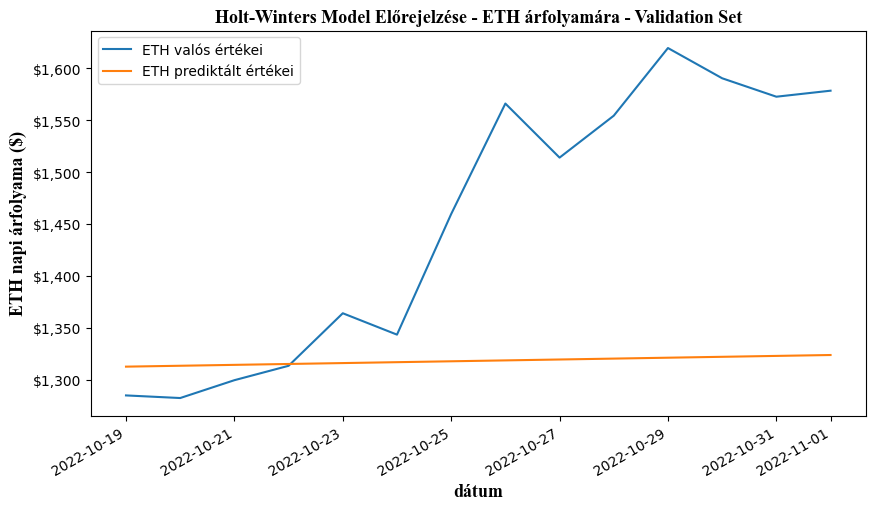

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(test["eth_close"], label="ETH valós értékei")
ax.plot(np.exp(fcast), label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
ax.set_title("Holt-Winters Model Előrejelzése - ETH árfolyamára - Validation Set", **font)
plt.savefig("charts/forecast/holt-winters_forecast_example.png")
plt.show()

In [38]:
test["eth_close"]

date
2022-10-19    1285.09
2022-10-20    1282.57
2022-10-21    1299.75
2022-10-22    1313.61
2022-10-23    1364.20
2022-10-24    1343.61
2022-10-25    1459.74
2022-10-26    1566.10
2022-10-27    1514.05
2022-10-28    1554.41
2022-10-29    1619.55
2022-10-30    1590.44
2022-10-31    1572.69
2022-11-01    1578.48
Freq: D, Name: eth_close, dtype: float64

In [39]:
np.exp(fcast)

2022-10-19    1312.791557
2022-10-20    1313.650027
2022-10-21    1314.509058
2022-10-22    1315.368651
2022-10-23    1316.228806
2022-10-24    1317.089523
2022-10-25    1317.950804
2022-10-26    1318.812647
2022-10-27    1319.675055
2022-10-28    1320.538026
2022-10-29    1321.401561
2022-10-30    1322.265661
2022-10-31    1323.130326
2022-11-01    1323.995557
Freq: D, dtype: float64

## Test on Real-World dataset

## 1 day real world prediction

In [40]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [41]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [42]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=0)] ## 1 day

In [43]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [44]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [45]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [46]:
eth_current_price.tail()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692


In [47]:
train = df_close.copy()

In [48]:
# best
# trend_type: add
# seasonal_type: None
# damped_trend: True
# init_method: legacy-heuristic

In [49]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="add",
      damped_trend=True,
      seasonal=None)

In [50]:
res = m.fit()

In [51]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [52]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [53]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.35299,1560.857227


In [54]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

26.768969782220665

In [55]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

716.5777432014431

In [56]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

26.768969782220665

In [57]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.01744943269263514

## Findings

1 day forecast
- RMSE: 26.76
- MSE: 716.57
- MAE: 26.76
- MAPE: 1.74

## 3 day real world prediction

In [58]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [59]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [60]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=2)] ## 1 day

In [61]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [62]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [63]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [64]:
eth_current_price.tail()

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841


In [65]:
train = df_close.copy()

In [66]:
# best
# trend_type: add
# seasonal_type: mul
# damped_trend: True
# init_method: legacy-heuristic

In [67]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="add",
      damped_trend=True,
      seasonal="mul",
      seasonal_periods=365)

In [68]:
res = m.fit()

In [69]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [70]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [71]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.357476,1567.874278
2023-03-09,1438.660767,7.271468,7.362879,1576.368798
2023-03-10,1429.158081,7.264841,7.348467,1553.812078


In [72]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

109.00094217798366

In [73]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

11881.205395688137

In [74]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

98.71601664427226

In [75]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.06832169906838244

## Findings

3 day forecast
- RMSE: 109.00
- MSE: 11881.20
- MAE: 98.71
- MAPE: 6.83

## 7 day real world prediction

In [76]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [77]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [78]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=6)] ## 1 day

In [79]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [80]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [81]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [82]:
eth_current_price

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444


In [83]:
train = df_close.copy()

In [84]:
# best
# trend_type: mul
# seasonal_type: None
# damped_trend: False
# init_method: estimated

In [85]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="estimated",
      trend="mul",
      damped_trend=False,
      seasonal=None)

In [86]:
res = m.fit()

In [87]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [88]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [89]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.354475,1563.176519
2023-03-09,1438.660767,7.271468,7.355067,1564.102051
2023-03-10,1429.158081,7.264841,7.355659,1565.028205
2023-03-11,1482.616699,7.301564,7.356251,1565.954983
2023-03-12,1590.292969,7.371674,7.356843,1566.882384
2023-03-13,1680.308960,7.426733,7.357435,1567.810409
2023-03-14,1703.507080,7.440444,7.358027,1568.739058


In [90]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

102.36768614095867

In [91]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

10479.14316585382

In [92]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

92.059301707931

In [93]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.05974554510949492

## Findings

7 day forecast
- RMSE: 102.36
- MSE: 10479.14
- MAE: 92.059
- MAPE: 5.97

## 14 day real world prediction

In [94]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-07', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)


In [95]:
eth_current_price.index = pd.to_datetime(eth_current_price.index)

In [96]:
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=13)] ## 1 day

In [97]:
eth_current_price["logclose"] = np.log(eth_current_price.Close)

In [98]:
eth_current_price = pd.DataFrame(eth_current_price[["Close", "logclose"]])

In [99]:
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)

In [100]:
eth_current_price

,eth_close,logclose
Date,,
2023-03-08,1534.088257,7.335692
2023-03-09,1438.660767,7.271468
2023-03-10,1429.158081,7.264841
2023-03-11,1482.616699,7.301564
2023-03-12,1590.292969,7.371674
2023-03-13,1680.308960,7.426733
2023-03-14,1703.507080,7.440444
2023-03-15,1656.180542,7.412269
2023-03-16,1677.215454,7.424890


In [101]:
train = df_close.copy()

In [102]:
# best
# trend_type: add
# seasonal_type: None
# damped_trend: False
# init_method: legacy-heuristic

In [103]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="add",
      damped_trend=False,
      seasonal=None)

In [104]:
res = m.fit()

In [105]:
eth_current_price["logprediction"] = res.forecast(len(eth_current_price))

In [106]:
eth_current_price["prediction"] = np.exp(eth_current_price["logprediction"])

In [107]:
eth_current_price

,eth_close,logclose,logprediction,prediction
Date,,,,
2023-03-08,1534.088257,7.335692,7.354585,1563.347551
2023-03-09,1438.660767,7.271468,7.355279,1564.433969
2023-03-10,1429.158081,7.264841,7.355974,1565.521142
2023-03-11,1482.616699,7.301564,7.356669,1566.609071
2023-03-12,1590.292969,7.371674,7.357363,1567.697755
2023-03-13,1680.308960,7.426733,7.358058,1568.787197
2023-03-14,1703.507080,7.440444,7.358753,1569.877395
2023-03-15,1656.180542,7.412269,7.359447,1570.968351
2023-03-16,1677.215454,7.424890,7.360142,1572.060065


In [108]:
## Validation Root Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=False)

145.57028183712563

In [109]:
## Validation Mean Squared Error
mean_squared_error(eth_current_price['eth_close'], eth_current_price["prediction"], squared=True)

21190.70695414019

In [110]:
## Validation Mean Absolute Error
mean_absolute_error(eth_current_price['eth_close'], eth_current_price["prediction"])

131.32877907027105

In [111]:
## Validation Mean Absolute Percentage Error
mean_absolute_percentage_error(eth_current_price['eth_close'], eth_current_price["prediction"])

0.07833252766682645

## Findings

14 day forecast
- RMSE: 145.57
- MSE: 21190.70
- MAE: 131.32

- MAPE: 7.83

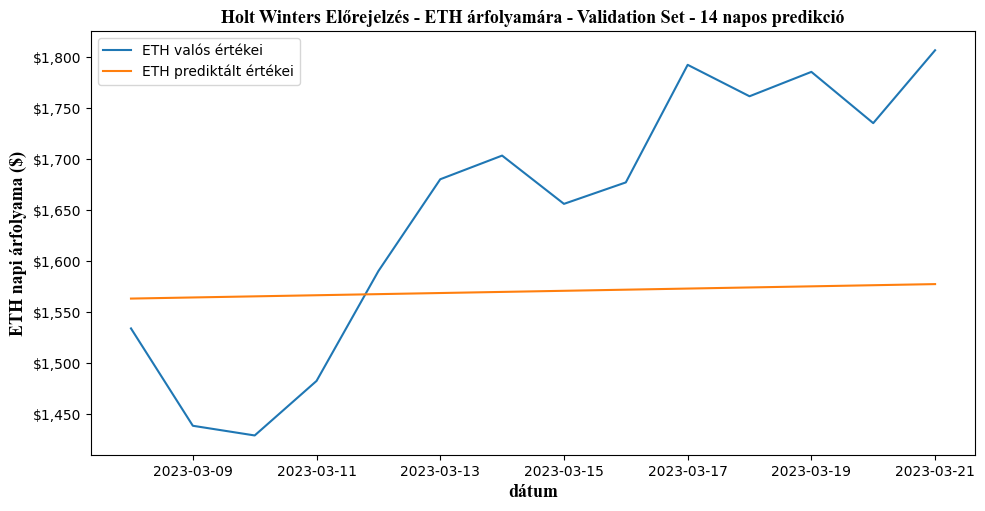

In [112]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(eth_current_price['eth_close'], label="ETH valós értékei")
ax.plot(eth_current_price['prediction'], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("Holt Winters Előrejelzés - ETH árfolyamára - Validation Set - 14 napos predikció", **font)
plt.savefig("charts/forecast/holt-winters-realword_forecast.png")
plt.show()

## BACKUP

In [113]:
## Forecast horizon
## Validation steps

h = qr ## ez maga a window size (seasonalitásnál fontos), hogy mekkora lépésközre prediktál, 365 napra előre pl
steps = 10 ## ez nem más, mint az, hogy 10 szer lép egyet előre az indexekben, magyarul ez a cv=10 kb Gridsearchnél
Ntest = len(df_close) - h -steps + 1 ## ez a kiindulási pont, érdemes lehet megnézni a 80%-körüli értéket

NameError: name 'qr' is not defined

In [ ]:
def walkforward(trend_type, seasonal_type, damped_trend, init_method, debug=False):

  # store errors
    errors = []
    seen_last = False
    steps_completed = 0

    for end_of_train in range(Ntest, len(df_close) - h + 1): ## plusz egy a range miatt van.
        train = df_close.iloc[:end_of_train] # one step walk
        test = df_close.iloc[end_of_train:end_of_train + h]

        if test.index[-1] == df.index[-1]:
            seen_last = True
      
        steps_completed += 1

        if seasonal_type != None:
            
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type,
                  seasonal_periods=365)
        else:
            hw = ExponentialSmoothing(
                  train['logclose'],
                  initialization_method=init_method,
                  trend=trend_type,
                  damped_trend=damped_trend,
                  seasonal=seasonal_type)
        
        res_hw = hw.fit()

      # compute error for the forecast horizon
        fcast = res_hw.forecast(h)
        error = mean_squared_error(test['logclose'], fcast, squared=False) ## root mean squared error
        errors.append(error)

    if debug:
            print("seen_last:", seen_last)
            print("steps completed:", steps_completed)

    return np.mean(errors)

In [ ]:
test_size = 14
train = df_close.iloc[:-test_size]
test = df_close.iloc[-test_size:]

In [ ]:
train_idx = df_close.index <= train.index[-1] ## csak belőjük a trainingset indexeit
test_idx = df_close.index > train.index[-1]

In [ ]:
m = ExponentialSmoothing(
      train['logclose'],
      initialization_method="legacy-heuristic",
      trend="mul",
      damped_trend=True,
      seasonal="add",
      seasonal_periods=365)

In [ ]:
res = m.fit()

In [ ]:
## Logarithmic prediction
df_close.loc[train_idx, "SESfitted"] = res.fittedvalues
df_close.loc[test_idx, "SESfitted"] = res.forecast(test_size) ##folytatjuk a trained (efelett) részt a predikcióval
df_close[["logclose", "SESfitted"]].plot(figsize=(10, 5))

In [ ]:
df_close["prediction"] = np.exp(df_close["SESfitted"])

In [ ]:
## Root Value prediction
df_close[["eth_close", "prediction"]].plot(figsize=(10, 5))

In [ ]:
## Validation Root Mean Squared Error
mean_squared_error(df_close['eth_close'].iloc[-test_size:], df_close["prediction"].iloc[-test_size:], squared=False)

In [ ]:
mean_absolute_error(df_close['eth_close'].iloc[-test_size:], df_close["prediction"].iloc[-test_size:])